1. Identify a dataset to study, and perform an exploratory analysis of the data. Describe the
dataset, including its basic statistics and properties, and report any interesting findings. This
exploratory analysis should motivate the design of your model in the following sections. Datasets
should be reasonably large (e.g. large enough to run the kinds of methods we’ve discussed in
class).


https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data

In [51]:
import numpy as np
import pandas as pd
from collections import defaultdict
import datetime
from dateutil.parser import parse
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [52]:
# Movies: 1 to 17770 
# Ratings: 1 to 5
# Users: 1 to 2649429, with gaps. There are 480189 users.

# ratingsByUserPerMovie = defaultdict(list)
data = []

# takes around a minute to load all ratings...
# data too big, so we are using 1 to 4499

# for i in range(1, 5):
for i in range(1, 2): # takes around 30 seconds to load
    print(f"Reading file {i}...")
    current_movie = None
    with open(f'data/combined_data_{i}.txt', 'r') as f:
        txt = f.readlines()
        for line in tqdm(txt):
            line = line.strip()
            if ':' in line: # movie_id:
                current_movie = line[:-1] 
            else:
                data.append([current_movie] + line.split(','))
#                 ratingsByUserPerMovie[int(current_movie)].append(line)

def format_line(line):
    split = line.split(',')
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = parse(split[2])
    return split

# this takes about 30 minutes to parse
# for k, v in tqdm(ratingsByUserPerMovie.items()): # ! only run once
#     lines = []
#     for line in v:
#         lines.append(format_line(line))
#     ratingsByUserPerMovie[k] = lines

Reading file 1...


100%|███████████████████████████████████| 24058263/24058263 [00:23<00:00, 1029564.70it/s]


In [53]:
# data
# MovieID, CustomerID, Rating, Rated Date

data = pd.DataFrame(data)
data.rename(columns={0: 'MovieID', 1: 'UserID', 2: 'Rating', 3: 'Rated Date'}, inplace=True)
data['MovieID'] = data['MovieID'].astype(int)
data['UserID'] = data['UserID'].astype(int)
data['Rating'] = data['Rating'].astype(int)
data['Rated Date'] = pd.to_datetime(data['Rated Date'])

In [54]:
data.head()

,MovieID,UserID,Rating,Rated Date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


In [55]:
# movies_titles.txt
# MovieID,YearOfRelease,Title

movies = pd.read_csv('data/movie_titles.csv',
                     usecols=range(3),
                     encoding="ISO-8859-1",
                    lineterminator='\n',
                    header=None)
movies.rename(columns={0: "MovieID", 1:"Released Date", 2:"Title"}, inplace=True)
movies['Title'] = movies['Title'].astype(str)

In [56]:
movies[movies.isna().any(axis=1)]

,MovieID,Released Date,Title
4387,4388,NaN,Ancient Civilizations: Rome and Pompeii
4793,4794,NaN,Ancient Civilizations: Land of the Pharaohs
7240,7241,NaN,Ancient Civilizations: Athens and Greece
10781,10782,NaN,Roti Kapada Aur Makaan
15917,15918,NaN,Hote Hote Pyaar Ho Gaya
16677,16678,NaN,Jimmy Hollywood
17666,17667,NaN,Eros Dance Dhamaka


In [57]:
# https://www.amazon.com/Ancient-Civilizations-Rome-Pompeii/dp/B00005MKKE
# Released date is 2002 for Ancient Civilizations: Rome and Pompeii
movies.loc[movies['MovieID'] == 4388, 'Released Date'] = 2002


# Other MovieIDs can be dropped since no other movies have been rated.
# data[data['MovieID'].isin(movies[movies.isna().any(axis=1)].MovieID)].MovieID.unique()
# array([4388])
movies.dropna(inplace=True)


movies['Released Date'] = movies['Released Date'].astype(int)

In [58]:
# Merge data with movies
data = data.merge(movies)
data.head()

,MovieID,UserID,Rating,Rated Date,Released Date,Title
0,1,1488844,3,2005-09-06,2003,Dinosaur Planet
1,1,822109,5,2005-05-13,2003,Dinosaur Planet
2,1,885013,4,2005-10-19,2003,Dinosaur Planet
3,1,30878,4,2005-12-26,2003,Dinosaur Planet
4,1,823519,3,2004-05-03,2003,Dinosaur Planet


In [59]:
movies.head()

,MovieID,Released Date,Title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW


## Plots

#### Basic

- Number of movies per release date
- Number of ratings per movie
- Average ratings per movie

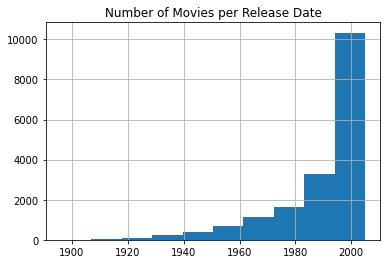

In [60]:
movies['Released Date'].hist()
plt.title("Number of Movies per Release Date")
plt.show()

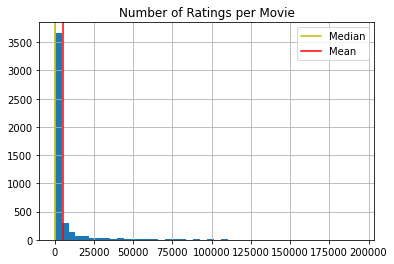

Mean nubmer of rating: 5346.46899310958
Median nubmer of rating: 552.0
Min number of rating: 36
Max number of rating: 193941


In [61]:
n = 4499

ratings = data.groupby('MovieID').count()['Rating']
ratings.hist(bins=n//100)
plt.axvline(ratings.median(), color='y', label="Median")
plt.axvline(ratings.mean(), color='r', label="Mean")
plt.title("Number of Ratings per Movie")
plt.legend()

plt.show()

print("Mean nubmer of rating:", ratings.mean())
print("Median nubmer of rating:", ratings.median())
print("Min number of rating:", ratings.min())
print("Max number of rating:", ratings.max())

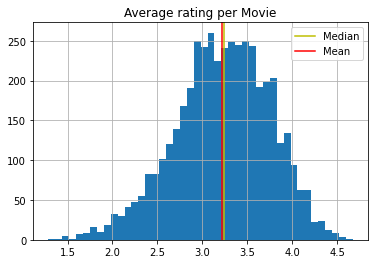

Mean rating: 3.2219446775168805
Median rating: 3.2447916666666665
Min rating: 1.2878787878787878
Max rating: 4.6709891019450955


In [62]:
n = 4499

ratings = data.groupby('MovieID')['Rating'].mean()
ratings.hist(bins=n//100)
plt.axvline(ratings.median(), color='y', label="Median")
plt.axvline(ratings.mean(), color='r', label="Mean")
plt.title("Average rating per Movie")
plt.legend()

plt.show()

print("Mean rating:", ratings.mean())
print("Median rating:", ratings.median())
print("Min rating:", ratings.min())
print("Max rating:", ratings.max())

### Insightful


#### Average and number of ratings per release date 
- Are movies released more recently more likely to recieve better ratings?
- See some trends throughout date.

#### Rating trend of movies.
- How do ratings change across time?
- Plot average rating since release date.


### ToDO
#### Word - Embeddings to Ratings
- Which movie titles contain words that are more significant to viewers?
- Extract words that correlate with better ratings.





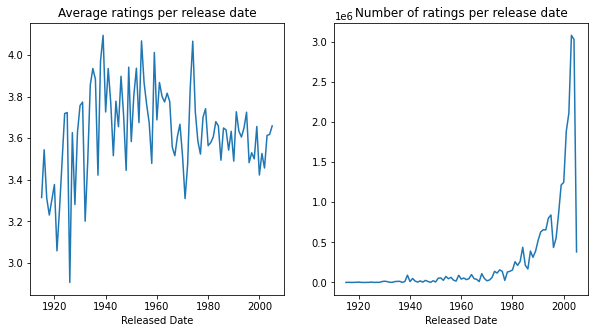

In [63]:
# Average and number of ratings per release date
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
data.groupby('Released Date')['Rating'].mean().plot(ax=axs[0])
axs[0].set_title('Average ratings per release date')
data.groupby('Released Date')['Rating'].count().plot(ax=axs[1])
axs[1].set_title('Number of ratings per release date')

plt.show()

In [97]:
data['Released Since'] = data['Rated Date'] - pd.to_datetime(data['Released Date'], format='%Y')
data[data['Released Since'].dt.days < 0]

,MovieID,UserID,Rating,Rated Date,Released Date,Title,Released Since


In [68]:
# Drop if rated date is before released date.
data = data[data['Released Since'].dt.days >= 0]
data.shape

(24053684, 7)

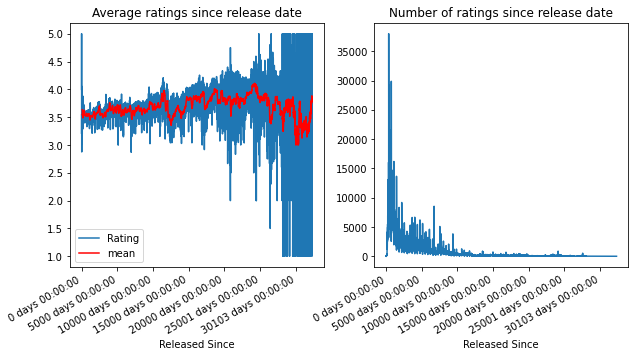

In [95]:
# Average and number of ratings per release date
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
data.groupby('Released Since')['Rating'].mean().plot(ax=axs[0])

rating_average = data.groupby('Released Since')['Rating'].mean().rolling(window=100).mean()
axs[0].plot(rating_average.values, 'r-', label='mean')
axs[0].legend()

axs[0].set_title('Average ratings since release date')
data.groupby('Released Since')['Rating'].count().plot(ax=axs[1])
axs[1].set_title('Number of ratings since release date')

plt.show()

In [96]:
# TODO

# Find something interesting about the titles

In [ ]:
# Average and number of ratings per release date
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
merged.groupby('Released Date')['Rating'].mean().plot(ax=axs[0])
axs[0].set_title('Average ratings per release date')
merged.groupby('Released Date')['Rating'].count().plot(ax=axs[1])
axs[1].set_title('Number of ratings per release date')

plt.show()

In [132]:
# TF-IDF of top 20 words vs ratings.

tfidf = TfidfVectorizer()
title = tfidf.fit_transform(movies['Title'])

feature_array = np.array(tfidf.get_feature_names())
tfidf_sorting = np.argsort(title.toarray()).flatten()[::-1]

n = 3
top_n = feature_array[tfidf_sorting][:n]

/home/mkim/miniconda3/envs/torch/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [133]:
top_n

array(['hunter', 'alien', 'zz'], dtype='<U16')

## Observations

## From ratings per Movie, we can see that there are "Top" movies.

## - More recent = More ratings and more movies 

## - Some trends in ratings


In [99]:
import sys
print(sys.getsizeof(data) / 1e6, 'MB')
print(sys.getsizeof(movies) / 1e6, 'MB')

3126.025752 MB
1.808075 MB


2. Identify a predictive task that can be studied on this dataset. Describe how you will evaluate
your model at this predictive task, what relevant baselines can be used for comparison, and how
you will assess the validity of your model’s predictions. It’s also important in this section to
carefully describe what features you will use and how you had to process the data to obtain them.
Make sure to select a task and models that are relevant to the course content; if you want to try
out models you’ve seen in other classes that’s fine, but you should still implement models from
this class as baselines / comparison points.

3. Describe your model. Explain and justify your decision to use the model you proposed. How
will you optimize it? Did you run into any issues due to scalability, overfitting, etc.? What other
models did you consider for comparison? What were your unsuccessful attempts along the way?
What are the strengths and weaknesses of the different models being compared?

4. Describe literature related to the problem you are studying. If you are using an existing dataset,
where did it come from and how was it used? What other similar datasets have been studied in
the past and how? What are the state-of-the-art methods currently employed to study this type
of data? Are the conclusions from existing work similar to or different from your own findings?

5. Describe your results and conclusions. How well does your model perform compared to alternatives, and what is the significance of the results? Which feature representations worked well and
which do not? What is the interpretation of your model’s parameters? Why did the proposed
model succeed why others failed (or if it failed, why did it fail)?